In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from pycaret.classification import *

In [2]:
seed = 42
np.random.seed(seed)
set_config('seed', seed)

# 1. 데이터 로드

In [3]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test_x.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [ ]:
train.shape, test.shape, submission.shape

# 2. EDA & 전처리

In [ ]:
df = pd.concat([train, test])
df.shape

In [ ]:
train.info

## Missing Value

In [ ]:
train.isnull().sum().sum()
test.isnull().sum().sum()

## 컬럼 분류

In [4]:
data = []

for f in train.columns:
    dtl = ''
    if f == 'voted':
        gubun = 'target'
    elif 'Q' in f:
        dtl = f[1]
        if 'A' in f:
            gubun = 'Q_A'
        if 'E' in f:
            gubun = 'Q_E'
    elif 'tp' in f:           
        gubun = 'tp'            
    elif 'wf' in f:           
        gubun = 'wf'
    elif 'wr' in f:           
        gubun = 'wr'    
    else:
        gubun = 'cat'
        
    f_dict = {
        'col':f,
        'gbn':gubun,
        'dtl':dtl
    }
            
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns =['col', 'gbn', 'dtl'])
meta.set_index('col', inplace=True)
meta

,gbn,dtl
col,,
QaA,Q_A,a
QaE,Q_E,a
QbA,Q_A,b
QbE,Q_E,b
QcA,Q_A,c
...,...,...
wr_09,wr,
wr_10,wr,
wr_11,wr,


### Q_A

In [5]:
Q_A = meta[meta.gbn=='Q_A'].index

train[Q_A].describe()
train[Q_A].head(3)

,QaA,QbA,QcA,QdA,QeA,QfA,QgA,QhA,QiA,QjA,QkA,QlA,QmA,QnA,QoA,QpA,QqA,QrA,QsA,QtA
count,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000
mean,2.129535,2.904463,3.662347,1.749078,2.317952,2.168145,2.560595,2.317952,3.157691,3.575529,3.813933,4.325727,3.509620,2.632896,3.217232,3.071752,2.840464,2.823487,3.432948,3.225687
std,1.196952,1.566142,1.431494,1.043625,1.369205,1.348653,1.510600,1.460813,1.481740,1.361220,1.372551,1.146992,1.375134,1.473022,1.476414,1.489744,1.404342,1.424383,1.374938,1.521603
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,3.000000,4.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,2.000000,3.000000,4.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,4.000000,4.000000,5.000000,4.000000,2.000000,4.000000,3.000000,3.000000,3.000000,4.000000,4.000000
75%,3.000000,4.000000,5.000000,2.000000,3.000000,3.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


,QaA,QbA,QcA,QdA,QeA,QfA,QgA,QhA,QiA,QjA,QkA,QlA,QmA,QnA,QoA,QpA,QqA,QrA,QsA,QtA
index,,,,,,,,,,,,,,,,,,,,
0,3.0,4.0,5.0,1.0,2.0,5.0,2.0,4.0,5.0,4.0,4.0,4.0,2.0,5.0,2.0,2.0,2.0,2.0,2.0,1.0
1,5.0,5.0,3.0,5.0,1.0,3.0,1.0,1.0,5.0,3.0,5.0,4.0,1.0,5.0,1.0,5.0,5.0,1.0,4.0,1.0
2,4.0,1.0,1.0,4.0,5.0,1.0,4.0,1.0,3.0,2.0,5.0,5.0,2.0,4.0,2.0,1.0,5.0,4.0,1.0,1.0


<AxesSubplot:>

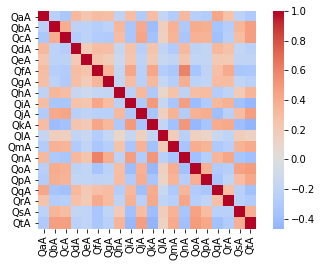

In [6]:
corr = train[Q_A].corr(method = 'spearman')
sns.heatmap(corr, cmap="coolwarm", square=True, center=0)

In [7]:
minus_cols = ["QeA", "QfA", "QkA", "QqA", "QrA","QaA", "QdA", "QgA", "QiA", "QnA"]
for f in minus_cols: 
    train[f] = train[f]*-1
    test[f] = test[f]*-1
train.head(3)    

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,,,,,,,,,
0,-3.0,363,4.0,1370,5.0,997,-1.0,1024,-2.0,1577,...,0,1,0,1,1,0,1,0,1,1
1,-5.0,647,5.0,1313,3.0,3387,-5.0,2969,-1.0,4320,...,1,1,0,1,1,0,1,0,1,1
2,-4.0,1623,1.0,1480,1.0,1021,-4.0,3374,-5.0,1333,...,1,1,0,1,1,1,1,0,1,1


In [8]:
train['Mach_score'] = train[Q_A].mean(axis = 1)
test['Mach_score'] = test[Q_A].mean(axis = 1)

### Q_E

In [9]:
Q_E = meta[meta.gbn == 'Q_E'].index

train[Q_E].describe()
train[Q_E].head()

,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,QjE,QkE,QlE,QmE,QnE,QoE,QpE,QqE,QrE,QsE,QtE
count,4.553200e+04,4.553200e+04,45532.000000,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,45532.000000,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04
mean,9.453570e+02,2.189589e+03,1484.294518,1.490672e+03,1.899292e+03,1.850650e+03,1.284608e+03,4.584272e+03,4.068434e+03,2.576363e+03,2.038986e+03,3.741018e+03,2.050287e+03,959.880502,1.435762e+03,1.633479e+03,1.154352e+03,2.470808e+03,1.164117e+03,2.240057e+03
std,1.307565e+04,3.351027e+04,8977.664318,1.092260e+04,1.670765e+04,7.608236e+04,9.756584e+03,5.020265e+05,1.141738e+05,5.411432e+04,3.069164e+04,3.663672e+05,7.530787e+04,5869.964127,1.084997e+04,2.600221e+04,2.250689e+04,1.482890e+05,7.433515e+03,6.730924e+04
min,2.500000e+01,2.500000e+01,25.000000,2.600000e+01,2.500000e+01,2.500000e+01,2.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+01,2.500000e+01,25.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+01,2.500000e+01,2.500000e+01
25%,4.040000e+02,8.750000e+02,651.000000,6.790000e+02,8.340000e+02,5.040000e+02,5.490000e+02,1.077000e+03,1.259000e+03,9.020000e+02,8.590000e+02,8.060000e+02,6.500000e+02,428.000000,6.380000e+02,7.060000e+02,4.610000e+02,7.940000e+02,5.270000e+02,7.330000e+02
50%,5.570000e+02,1.218000e+03,899.000000,9.310000e+02,1.154000e+03,7.120000e+02,7.720000e+02,1.464000e+03,1.800000e+03,1.260000e+03,1.178000e+03,1.125000e+03,9.060000e+02,596.000000,8.830000e+02,9.700000e+02,6.520000e+02,1.117000e+03,7.470000e+02,1.020000e+03
75%,8.270000e+02,1.838000e+03,1335.000000,1.355000e+03,1.656000e+03,1.078000e+03,1.150000e+03,2.090000e+03,2.761000e+03,1.899000e+03,1.721000e+03,1.649000e+03,1.342000e+03,891.000000,1.300000e+03,1.409000e+03,9.820000e+02,1.664000e+03,1.124000e+03,1.526000e+03
max,2.413960e+06,5.580395e+06,871557.000000,1.552821e+06,1.919926e+06,1.176370e+07,1.068252e+06,1.070860e+08,1.703586e+07,9.910006e+06,4.824953e+06,7.754351e+07,1.410832e+07,606694.000000,1.309739e+06,4.650742e+06,4.277510e+06,3.159328e+07,1.286581e+06,1.155650e+07


,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,QjE,QkE,QlE,QmE,QnE,QoE,QpE,QqE,QrE,QsE,QtE
index,,,,,,,,,,,,,,,,,,,,
0,363,1370,997,1024,1577,539,586,1095,1142,1287,883,851,851,816,579,924,366,876,633,1115
1,647,1313,3387,2969,4320,2190,826,4082,1867,1264,2943,3927,4329,1828,1214,2414,1356,3039,4304,1346
2,1623,1480,1021,3374,1333,531,1167,1016,2653,1569,998,2547,918,2153,1304,1131,937,1327,1170,1409
3,504,2311,992,3245,357,1519,159,2275,2809,5614,3219,1296,9046,1216,1169,23868,581,8830,2392,1312
4,927,707,556,1062,1014,628,991,1259,1153,1388,740,1181,547,575,754,1140,323,1070,583,1889


In [10]:
train[Q_E]

,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,QjE,QkE,QlE,QmE,QnE,QoE,QpE,QqE,QrE,QsE,QtE
index,,,,,,,,,,,,,,,,,,,,
0,363,1370,997,1024,1577,539,586,1095,1142,1287,883,851,851,816,579,924,366,876,633,1115
1,647,1313,3387,2969,4320,2190,826,4082,1867,1264,2943,3927,4329,1828,1214,2414,1356,3039,4304,1346
2,1623,1480,1021,3374,1333,531,1167,1016,2653,1569,998,2547,918,2153,1304,1131,937,1327,1170,1409
3,504,2311,992,3245,357,1519,159,2275,2809,5614,3219,1296,9046,1216,1169,23868,581,8830,2392,1312
4,927,707,556,1062,1014,628,991,1259,1153,1388,740,1181,547,575,754,1140,323,1070,583,1889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45527,1050,619,328,285,602,267,315,483,1016,278,611,215,388,299,1915,439,823,309,586,2252
45528,581,1353,1164,798,1680,560,640,1415,4494,1392,2478,1268,843,1401,1524,719,754,1118,654,1197
45529,593,857,1047,1515,1690,1253,1094,1283,2209,1764,1062,1489,1908,891,1298,1200,473,1779,1355,667


### tp

In [11]:
# 0~7 
tp = meta[meta.gbn=='tp'].index

train[tp].describe()
train[tp].head(3)

,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10
count,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000
mean,3.017241,2.621189,1.768712,3.041246,1.335918,2.472217,2.031099,3.507226,2.277497,4.317996
std,2.007713,1.897081,1.685069,2.037278,1.452544,2.000658,1.785824,1.971456,1.848783,1.722793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,3.000000
50%,3.000000,2.000000,1.000000,3.000000,1.000000,2.000000,2.000000,4.000000,2.000000,5.000000
75%,5.000000,4.000000,3.000000,5.000000,2.000000,4.000000,3.000000,5.000000,4.000000,6.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10
index,,,,,,,,,,
0,2,2,2,1,2,1,7,4,4,3
1,1,1,0,0,1,2,3,4,0,4
2,2,3,1,5,3,4,2,6,1,3


In [12]:
minus_cols = ["tp02", "tp04", "tp06", "tp08", "tp10"]

for f in minus_cols: 
    train[f] = train[f]*-1
    test[f] = test[f]*-1
train[tp].head(3)    

,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10
index,,,,,,,,,,
0,2,-2,2,-1,2,-1,7,-4,4,-3
1,1,-1,0,0,1,-2,3,-4,0,-4
2,2,-3,1,-5,3,-4,2,-6,1,-3


In [13]:
train['Extraversion'] = train[['tp01','tp06']].mean(axis = 1)
train['Agreeableness'] = train[['tp02','tp07']].mean(axis = 1)
train['Conscientiousness'] = train[['tp03','tp08']].mean(axis = 1)
train['EmotionalStability'] = train[['tp04','tp09']].mean(axis = 1)
train['OpennesstoExperience'] = train[['tp05','tp10']].mean(axis = 1)

test['Extraversion'] = test[['tp01','tp06']].mean(axis = 1)
test['Agreeableness'] = test[['tp02','tp07']].mean(axis = 1)
test['Conscientiousness'] = test[['tp03','tp08']].mean(axis = 1)
test['EmotionalStability'] = test[['tp04','tp09']].mean(axis = 1)
test['OpennesstoExperience'] = test[['tp05','tp10']].mean(axis = 1)

## WF WR

In [14]:
# 0/1
wf = meta[meta.gbn=='wf'].index
train[wf].describe()
train[wf].head(3)

,wf_01,wf_02,wf_03
count,45532.000000,45532.000000,45532.000000
mean,0.079592,0.163665,0.118356
std,0.270664,0.369975,0.323033
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


,wf_01,wf_02,wf_03
index,,,
0,0,0,0
1,0,0,0
2,0,0,1


In [15]:
train['wf'] = train['wf_01']+train['wf_02']+train['wf_03']
test['wf'] = test['wf_01']+test['wf_02']+test['wf_03']

In [16]:
# 0/1
wr = meta[meta.gbn=='wr'].index
train[wr].describe()
train[wr].head(3)

,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
count,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000
mean,0.709721,0.934793,0.208974,0.868708,0.895722,0.328538,0.938900,0.972195,0.202824,0.946104,0.395195,0.947729,0.927040
std,0.453896,0.246893,0.406580,0.337723,0.305625,0.469687,0.239516,0.164414,0.402107,0.225815,0.488898,0.222575,0.260073
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,
0,0,1,0,0,1,0,1,1,0,1,0,1,1
1,0,1,0,1,1,0,1,1,0,1,0,1,1
2,1,1,0,1,1,0,1,1,1,1,0,1,1


In [17]:
train['wr'] = 0
test['wr'] = 0
for f in wr:
    train['wr'] = train['wr'] + train[f]
    test['wr'] = test['wr'] + test[f]

## Target Encoding

### age_group

In [18]:
train['age_group_int'] = train['age_group'].str.replace('s','').astype('int')
test['age_group_int'] = test['age_group'].str.replace('s','').astype('int')

In [19]:
train['age_group_n_rows'] = train['age_group_int'].map(train.groupby('age_group_int').size())
test['age_group_n_rows'] = test['age_group_int'].map(test.groupby('age_group_int').size())

In [20]:
age_group_mean = train.groupby('age_group_int')['voted'].mean()
train['age_group_mean'] = train['age_group_int'].map(age_group_mean)
test['age_group_mean'] = test['age_group_int'].map(age_group_mean)

In [21]:
# train['voted'].mean() = 1.5468242115435298
def smoothing(n_rows, target_mean): 
    return (target_mean*n_rows + 1.5468242115435298*0.8) / (n_rows + 0.8)

In [22]:
train['age_group_mean_smoothing'] = train.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)
test['age_group_mean_smoothing'] = test.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)

In [23]:
train.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)
test.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)

### outlier

In [24]:
train = train[train.familysize < 25]

In [25]:
num = 1000
train['familysize_group'] = pd.qcut(train.familysize, num, duplicates='drop')
test['familysize_group'] = pd.qcut(test.familysize, num, duplicates='drop')

In [26]:
train['familysize_group'].value_counts()

(1.0, 2.0]       17918
(2.0, 3.0]       11256
(-0.001, 1.0]     7752
(3.0, 4.0]        4907
(4.0, 5.0]        1962
(5.0, 6.0]         838
(6.0, 7.0]         387
(7.0, 8.0]         221
(8.0, 9.0]         126
(9.0, 10.0]         59
(10.0, 11.0]        39
(12.0, 21.0]        38
(11.0, 12.0]        21
Name: familysize_group, dtype: int64

In [27]:
test['familysize_group'].value_counts()

(1.0, 2.0]       4454
(2.448, 3.0]     2836
(-0.001, 1.0]    1966
(3.0, 4.0]       1237
(4.0, 5.0]        495
(5.0, 6.0]        185
(6.0, 7.0]         97
(7.0, 8.0]         51
(8.0, 9.0]         28
(9.0, 10.0]        18
(11.0, 23.0]       10
(10.0, 11.0]        6
(2.0, 2.448]        0
Name: familysize_group, dtype: int64

# 3. 모델 학습

In [28]:
#col_cat = meta[(meta.gbn == 'Q_A') | (meta.gbn == 'cat')].index.values.tolist()
col_cat = ['QaA',
 'QbA',
 'QcA',
 'QdA',
 'QeA',
 'QfA',
 'QgA',
 'QhA',
 'QiA',
 'QjA',
 'QkA',
 'QlA',
 'QmA',
# 'QnA',
 'QoA',
 'QpA',
 'QqA',
 'QrA',
 'QsA',
 'QtA',
 'age_group',
 'education',
 'engnat',
 'familysize',
 'gender',
 'hand',
 'married',
 'race',
 'religion',
 'urban'
#,'Priority'
          ]

In [29]:
%%time
clf = setup(session_id=seed, 
            data = train, target = 'voted'
          , categorical_features=col_cat
          , numeric_features = ['wr','wf']#,,'tp17','tp4','Q_A15','Q_A3','Q_A15tp17','Q_A3tp4']#['Q_A1','Q_A3','Q_A5','tp17','tp4','Q_A15tp17','Q_A3tp4']
          , ignore_features =['QnA','QgE']+tp.tolist() + wr.tolist() + wf.tolist()#'religion', 'race_1', 'race_2', 'race_3','race_4', 'race_5', 'race_6']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"1: 0, 2: 1"
3,Original Data,"(45524, 87)"
4,Missing Values,False
5,Numeric Features,30
6,Categorical Features,56
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 19 s


In [30]:
best_3 = compare_models(sort = 'AUC', n_select = 3
                       ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'xgboost']
                       )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,CatBoost Classifier,0.6947,0.7679,0.6596,0.7516,0.7026,0.3916,0.3952,21.5373
1,Gradient Boosting Classifier,0.6951,0.7670,0.6483,0.7591,0.6993,0.3940,0.3991,19.8988
2,Light Gradient Boosting Machine,0.6907,0.7636,0.6484,0.7519,0.6963,0.3847,0.3891,1.8239
3,Linear Discriminant Analysis,0.6899,0.7621,0.6631,0.7424,0.7005,0.3812,0.3839,0.7551
4,Extra Trees Classifier,0.6915,0.7613,0.6384,0.7592,0.6936,0.3876,0.3936,2.7824
5,Ada Boost Classifier,0.6882,0.7575,0.6546,0.7445,0.6966,0.3787,0.3821,4.6439
6,Extreme Gradient Boosting,0.6705,0.7426,0.6638,0.7137,0.6878,0.3400,0.3410,9.6222
7,Random Forest Classifier,0.6605,0.7159,0.6041,0.7288,0.6605,0.3269,0.3327,0.2591


In [31]:
blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6970,0.7685,0.6512,0.7603,0.7015,0.3976,0.4025
1,0.7021,0.7732,0.6574,0.7649,0.7071,0.4075,0.4123
2,0.6902,0.7709,0.6462,0.7523,0.6952,0.3839,0.3885
3,0.6862,0.7615,0.6437,0.7473,0.6916,0.3757,0.3801
4,0.6927,0.7693,0.6445,0.7572,0.6963,0.3893,0.3945
Mean,0.6936,0.7687,0.6486,0.7564,0.6984,0.3908,0.3956
SD,0.0055,0.0040,0.0051,0.0061,0.0054,0.0110,0.0111


In [32]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.6939,0.7649,0.6459,0.7585,0.6977,0.3918,0.397


In [33]:
%%time
final_model = finalize_model(blended)

Wall time: 6min 44s


In [34]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [35]:
submission['voted'] = predictions['Score']

# 5. 제출

In [36]:
submission.to_csv('output/20201023-1.csv')

In [37]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7060,0.7798,0.6631,0.7676,0.7115,0.4149,0.4196
1,0.6849,0.7525,0.6426,0.7460,0.6904,0.3732,0.3775
2,0.6916,0.7648,0.6500,0.7524,0.6974,0.3864,0.3907
3,0.7163,0.7820,0.6648,0.7836,0.7193,0.4364,0.4424
4,0.7064,0.7757,0.6607,0.7698,0.7111,0.4162,0.4212
5,0.6795,0.7637,0.6320,0.7435,0.6832,0.3632,0.3682
6,0.6996,0.7652,0.6467,0.7675,0.7020,0.4035,0.4095
7,0.6888,0.7567,0.6481,0.7488,0.6948,0.3807,0.3848
8,0.7013,0.7761,0.6423,0.7730,0.7016,0.4077,0.4148
9,0.6771,0.7536,0.6325,0.7392,0.6817,0.3581,0.3626


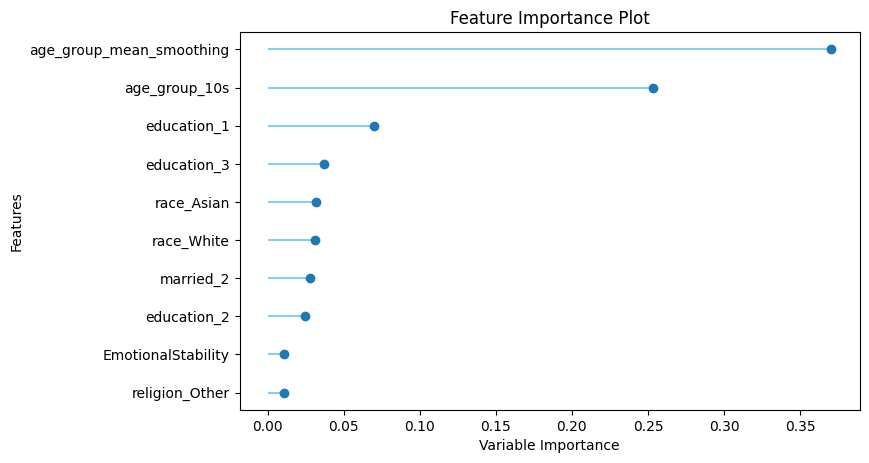

In [38]:
plot_model(estimator = gbc, plot = 'feature')

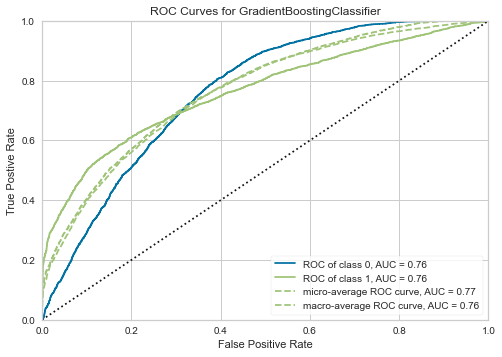

In [39]:
plot_model(estimator = gbc, plot = 'auc')

In [40]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7082,0.7768,0.6623,0.7717,0.7128,0.4197,0.4248
1,0.6885,0.7551,0.6533,0.7456,0.6964,0.3794,0.3829
2,0.6831,0.7559,0.6426,0.7431,0.6892,0.3694,0.3735
3,0.7037,0.7759,0.6615,0.7649,0.7095,0.4104,0.4150
4,0.6997,0.7764,0.6598,0.7594,0.7061,0.4022,0.4063
5,0.6907,0.7640,0.6443,0.7543,0.6950,0.3852,0.3902
6,0.6861,0.7564,0.6344,0.7529,0.6886,0.3768,0.3824
7,0.6830,0.7545,0.6374,0.7457,0.6873,0.3698,0.3745
8,0.6964,0.7724,0.6546,0.7571,0.7022,0.3959,0.4003
9,0.6677,0.7484,0.6341,0.7238,0.6760,0.3380,0.3411


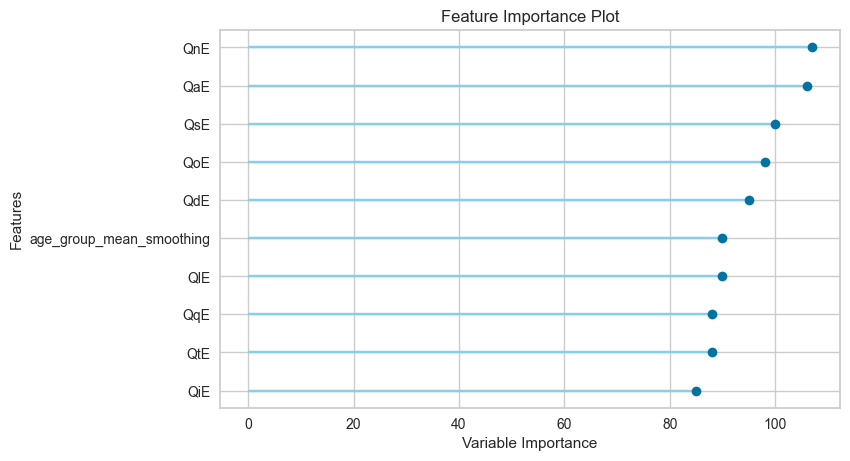

In [41]:
plot_model(estimator = lightgbm, plot = 'feature')

In [42]:
train.corr()['voted'].sort_values(ascending=False)[:30]

voted                       1.000000
age_group_mean_smoothing    0.405211
QqA                         0.123243
Conscientiousness           0.109956
Mach_score                  0.102134
tp08                        0.099416
QbA                         0.099139
QtA                         0.092496
Agreeableness               0.090773
QkA                         0.089470
tp07                        0.088677
QpA                         0.085127
QjA                         0.083177
EmotionalStability          0.082960
tp03                        0.082317
QmA                         0.081630
tp09                        0.078998
QoA                         0.072741
QsA                         0.066086
tp04                        0.065386
urban                       0.064473
tp06                        0.060116
QiA                         0.057109
tp02                        0.056078
QhA                         0.051616
QnA                         0.050797
Extraversion                0.050426
Q